# Examine the regulatory scores associated with eQTLs

In [1]:
import gzip
from genome import Genome
genome = Genome('../snps/hg19.fa')

243573 243573
(156234, 4096) (156234,)
SpearmanrResult(correlation=0.32440179421505078, pvalue=0.0)
(0.37180513520584529, 0.0)


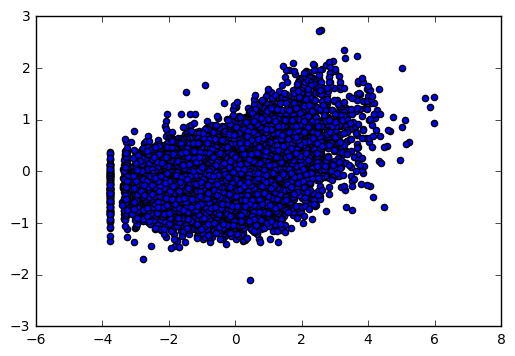

In [2]:
from kmer_model import kmer_model, predict, score_batch
model = kmer_model('../enhancer_data/kellis/standard/HepG2_ScaleUpDesign1_SV40P.fa',
                   '../enhancer_activities/kellis_HepG2_ScaleUpDesign1_SV40P.activities')

# Load eQTLs

In [6]:
predictor = lambda seqs: predict(seqs, model, 6)

BATCH = 128
LENGTH = 145
count = 0
sig_ref_preds = []
sig_alt_preds = []
sig_pvals = []
with gzip.open('../snps/GTEx_Analysis_v6p_eQTL/Liver_Analysis.v6p.signif_snpgene_pairs.txt.gz') as fp:
    print fp.readline()
    batch = []
    for line in fp:
        variant_id = line.split()[0]
        chrom, pos, ref, alt = variant_id.split('_')[:4]
        pval = float(line.split()[3])
        batch += [('chr' + chrom, int(pos)-1, ref, alt)]
        sig_pvals += [pval]
        if len(batch) == BATCH:
            rp, ap = score_batch(batch, predictor, genome, LENGTH)
            sig_ref_preds += list(rp)
            sig_alt_preds += list(ap)
            batch = []
    rp, ap = score_batch(batch, predictor, genome, LENGTH)
    sig_ref_preds += list(rp)
    sig_alt_preds += list(ap)

variant_id	gene_id	tss_distance	pval_nominal	slope	slope_se	slope_fpkm	slope_fpkm_se	pval_nominal_threshold	min_pval_nominal	pval_beta



# Look for Correlations between p-vals and activity

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

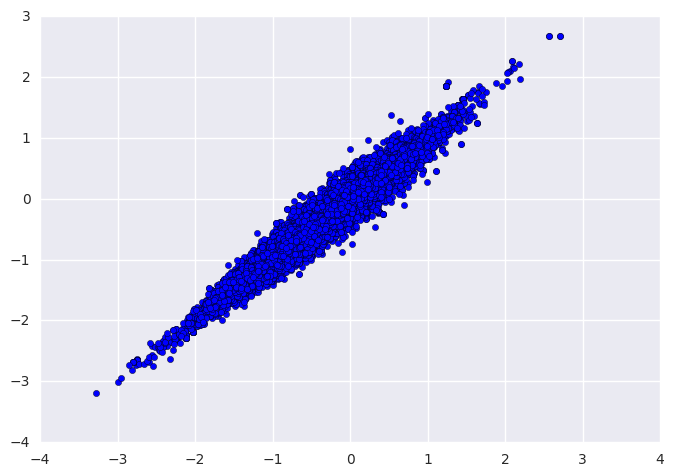

Ttest_relResult(statistic=-0.38133708921177645, pvalue=0.70295356446699597)
Ttest_indResult(statistic=-0.056683223998028567, pvalue=0.95479756779386948)


In [23]:
plt.scatter(sig_ref_preds, sig_alt_preds)
plt.show()
print stats.ttest_rel(sig_ref_preds, sig_alt_preds)
print stats.ttest_ind(sig_ref_preds, sig_alt_preds)

0.0 -9.09141858427e-05


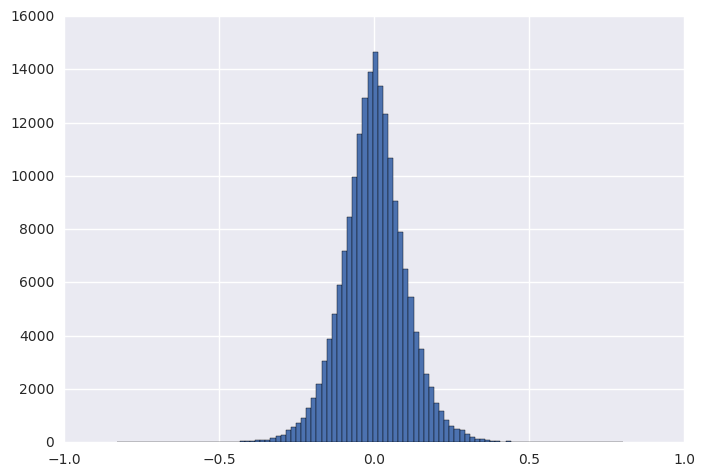

In [25]:
diff = np.array(sig_ref_preds) - np.array(sig_alt_preds)
print np.median(diff), np.mean(diff)
plt.hist(diff, bins = 100)
plt.show()

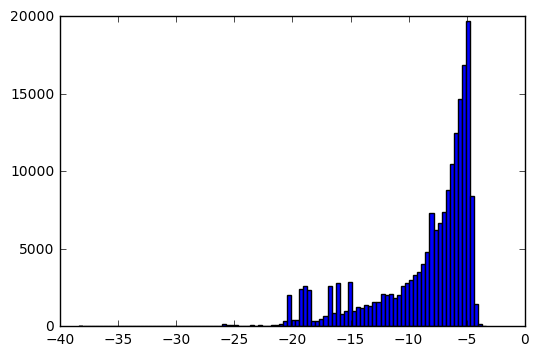

In [15]:
plt.hist(np.log10(sig_pvals), bins = 100)
plt.show()

SpearmanrResult(correlation=-0.042360588585356712, pvalue=8.2462622960261515e-76)


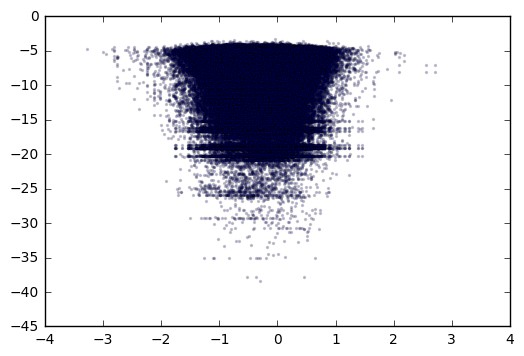

In [16]:
print stats.spearmanr(sig_ref_preds, sig_pvals)
plt.scatter(sig_ref_preds, np.log10(sig_pvals), s = 2, alpha = .2)
plt.show()

SpearmanrResult(correlation=0.0016946280516688535, pvalue=0.46126390995449784)


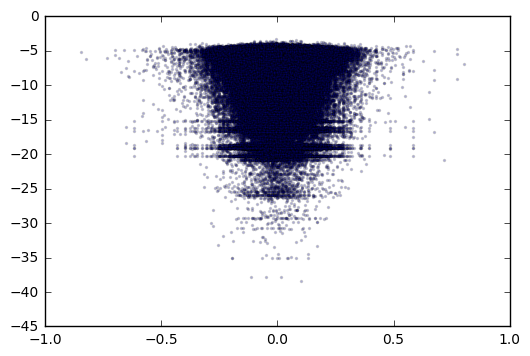

In [17]:
print stats.spearmanr(np.abs(diff), sig_pvals)
plt.scatter(diff, np.log10(sig_pvals), s = 2, alpha = .2)
plt.show()

In [24]:
predictor = lambda seqs: predict(seqs, model, 6)

BATCH = 128
LENGTH = 145
count = 0
all_ref_preds, all_alt_preds, all_pvals = [], [], []
with gzip.open('../snps/Liver_Analysis.v6p.all_snpgene_pairs.txt.gz') as fp:
    print fp.readline()
    batch = []
    for line in fp:
        count += 1
        if count == 189024: break
        variant_id = line.split()[1]
        chrom, pos, ref, alt = variant_id.split('_')[:4]
        pval = float(line.split()[3])
        batch += [('chr' + chrom, int(pos)-1, ref, alt)]
        all_pvals += [pval]
        if len(batch) == BATCH:
            rp, ap = score_batch(batch, predictor, genome, LENGTH)
            all_ref_preds += list(rp)
            all_alt_preds += list(ap)
            batch = []
    rp, ap = score_batch(batch, predictor, genome, LENGTH)
    all_ref_preds += list(rp)
    all_alt_preds += list(ap)

gene_id	variant_id	tss_distance	pval_nominal	slope	slope_se



# CDF of all v. Sig

Ttest_indResult(statistic=217.61986680449945, pvalue=0.0)
0.0293633176338 -0.305003106917


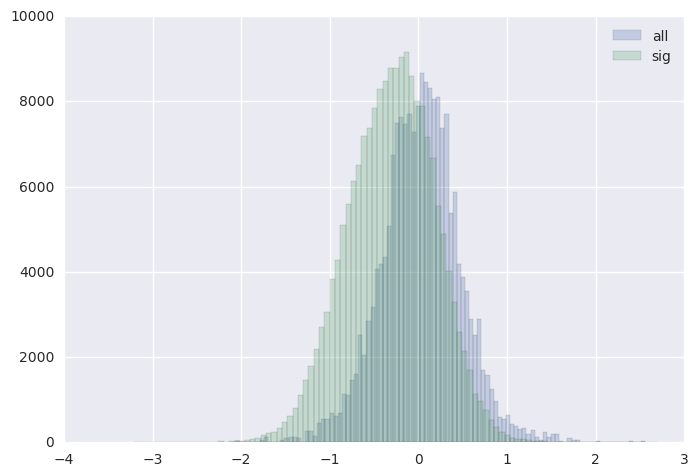

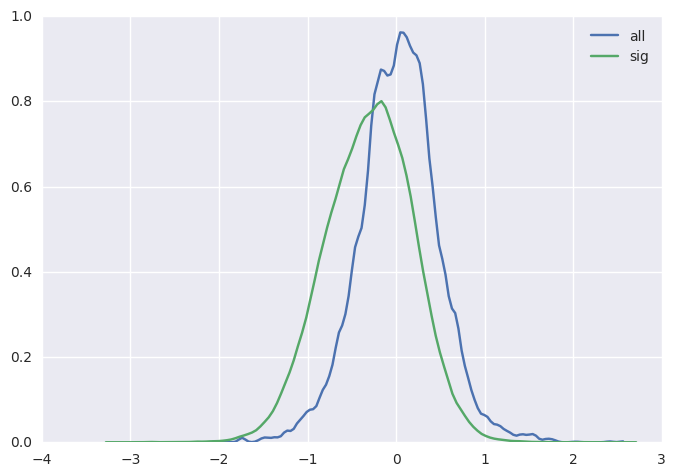

In [20]:
import seaborn as sns
a = np.array(all_ref_preds)
s = np.array(sig_ref_preds)
print stats.ttest_ind(a, s)
print a.mean(), s.mean()

plt.hist(a, bins = 100, alpha = .25, label = 'all')
plt.hist(s, bins = 100, alpha = .25, label = 'sig')

plt.legend()
plt.show()
sns.kdeplot(a, cut = 0, label = 'all')
sns.kdeplot(s, cut = 0, label = 'sig')
plt.show()

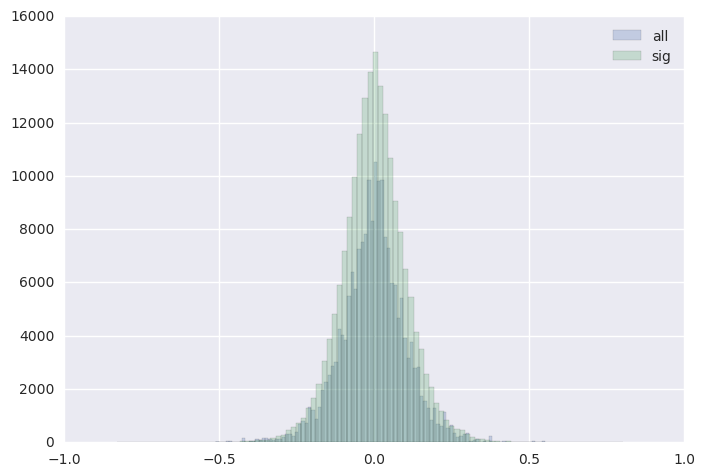

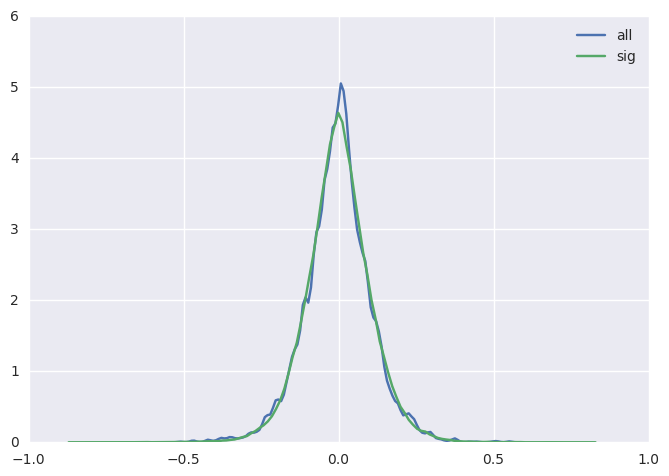

In [21]:
all_diff = np.array(all_ref_preds) -  np.array(all_alt_preds)
sig_diff = np.array(sig_ref_preds) -  np.array(sig_alt_preds)
plt.hist(all_diff, bins = 100, alpha = .25, label = 'all')
plt.hist(sig_diff, bins = 100, alpha = .25, label = 'sig')
plt.legend()
plt.show()
sns.kdeplot(all_diff, label = 'all')
sns.kdeplot(sig_diff, label = 'sig')
plt.show()